## MTSIM


In [1]:
from typing import List, Tuple, Dict, Any, Optional, Union, Callable
import os

import copy
from datetime import datetime
from pathos.multiprocessing import ProcessingPool as Pool

import numpy as np
from scipy.special import expit

import matplotlib.pyplot as plt
import matplotlib.cm as plt_cm
import matplotlib.colors as plt_colors
import plotly.graph_objects as go
import pandas as pd
import gym
from gym import spaces
from gym.utils import seeding
import pytz
from datetime import datetime, timedelta
import numpy as np
from datetime import datetime, timedelta

from finta import TA

In [2]:
from gym_mtsim import MtSimulator, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

In [3]:
# Moved this into its own class as calculating on multiprocessing is very slow - do once and reuse

class dataHandler():

    def __init__(
        self, original_simulator: MtSimulator, 
        trading_symbols: List[str], 
        time_points: Optional[List[datetime]]=None, 
        window_size = 10,
        ) -> None:

        self.original_simulator = original_simulator
        self.trading_symbols = trading_symbols

        if time_points is None:
            time_points = original_simulator.symbols_data[trading_symbols[0]].index.to_pydatetime().tolist()
        assert len(time_points) > window_size, "not enough time points provided"

        self.time_points = time_points

    def _get_prices(self, keys: List[str]=['Close','Open', 'High','Low']) -> Dict[str, np.ndarray]:
        prices = {}

        for symbol in self.trading_symbols:
            get_price_at = lambda time: \
                self.original_simulator.price_at(symbol, time)[keys]

            p = list(map(get_price_at, self.time_points))

            temp1 = pd.DataFrame(p)

            temp1.rename(columns={"close": "Close", "open": "Open", 'high': 'High', 'low': 'Low'})

            temp1['SSMA20'] = TA.SSMA(temp1, 20) #- self.dataDF['close']
            temp1['SSMA100'] = TA.SSMA(temp1, 100) #- self.dataDF['close']
            temp1['RSI'] = TA.RSI(temp1, period=20) #['BB_UPPER'] #- self.dataDF['close']
            temp1['BB_UPPER'] = TA.BBANDS(temp1, period=20)['BB_UPPER'] #- self.dataDF['close']
            temp1['BB_LOWER'] = TA.BBANDS(temp1, period = 20 )['BB_LOWER'] #- self.dataDF['close']

            temp1.rename(columns={"Close": "close", "Open": "open"},inplace=True)
            temp1.drop(['open', 'High', 'Low'], axis=1)

            # we cant just drop the nan's because that gives incomplete time points. Fill them in
            temp1.fillna(None, method='backfill', inplace = True)

            p = [row for i, row in temp1.iterrows()]

            prices[symbol] = np.array(p)

        return prices, self.time_points

In [4]:
from enum import Enum
#Again not wanting to worry about logits - although this will make multicurrency harder later - but can revisit.
class Actions(Enum):
    Sell = 0
    Buy = 1
    Close = 2
    Hold = 3

In [5]:
class MtEnv(gym.Env):

    metadata = {'render.modes': ['human', 'simple_figure', 'advanced_figure']}

    def __init__(
            self, original_simulator: MtSimulator, trading_symbols: List[str],
            window_size: int,priceData, time_points: Optional[List[datetime]]=None,
            hold_threshold: float=0.5, close_threshold: float=0.5,
            fee: Union[float, Callable[[str], float]]=0.0005,
            symbol_max_orders: int=1, multiprocessing_processes: Optional[int]=None
        ) -> None:

        # validations
        assert len(original_simulator.symbols_data) > 0, "no data available"
        assert len(original_simulator.symbols_info) > 0, "no data available"
        assert len(trading_symbols) > 0, "no trading symbols provided"
        assert 0. <= hold_threshold <= 1., "'hold_threshold' must be in range [0., 1.]"

        if not original_simulator.hedge:
            symbol_max_orders = 1

        for symbol in trading_symbols:
            assert symbol in original_simulator.symbols_info, f"symbol '{symbol}' not found"
            currency_profit = original_simulator.symbols_info[symbol].currency_profit
            assert original_simulator._get_unit_symbol_info(currency_profit) is not None, \
                   f"unit symbol for '{currency_profit}' not found"

        if time_points is None:
            time_points = original_simulator.symbols_data[trading_symbols[0]].index.to_pydatetime().tolist()
        assert len(time_points) > window_size, "not enough time points provided"

        # attributes
        self.seed()
        self.original_simulator = original_simulator
        self.trading_symbols = trading_symbols
        self.window_size = window_size
        self.time_points = time_points
        self.hold_threshold = hold_threshold
        self.close_threshold = close_threshold
        self.fee = fee
        self.symbol_max_orders = symbol_max_orders
        self.multiprocessing_pool = Pool(multiprocessing_processes) if multiprocessing_processes else None

        self.prices = priceData
        self.signal_features = self._process_data()
        self.features_shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Box(
            low=-99999999999999, high=9999999999999,
            shape=(len(self.trading_symbols) * (self.symbol_max_orders + 2),)
        )  # symbol -> [close_order_i(logit), hold(logit), volume]

        #Actions
        # self.action_space = spaces.Discrete(len(Actions))

        self.action_space = spaces.MultiDiscrete([len(self.trading_symbols), len(Actions)])    
        
        self.observation_space = spaces.Dict({
            'balance': spaces.Box(low=-np.inf, high=np.inf, shape=(1,)),
            'equity': spaces.Box(low=-np.inf, high=np.inf, shape=(1,)),
            'margin': spaces.Box(low=-np.inf, high=np.inf, shape=(1,)),
            'features': spaces.Box(low=-np.inf, high=np.inf, shape=self.features_shape),
            'orders': spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(len(self.trading_symbols), self.symbol_max_orders, 3)
            )  # symbol, order_i -> [entry_price, volume, profit]
        })

        # episode
        self._start_tick = self.window_size - 1
        self._end_tick = len(self.time_points) - 1
        self._done: bool = NotImplemented
        self._current_tick: int = NotImplemented
        self.simulator: MtSimulator = NotImplemented
        self.history: List[Dict[str, Any]] = NotImplemented


    def seed(self, seed: Optional[int]=None) -> List[int]:
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self) -> Dict[str, np.ndarray]:
        self._done = False
        self._current_tick = self._start_tick
        self.simulator = copy.deepcopy(self.original_simulator)
        self.simulator.current_time = self.time_points[self._current_tick]
        self.history = [self._create_info()]
        return self._get_observation()


    def step(self, action: np.ndarray) -> Tuple[Dict[str, np.ndarray], float, bool, Dict[str, Any]]:
        orders_info, closed_orders_info = self._apply_action(action)

        self._current_tick += 1
        if self._current_tick == self._end_tick:
            self._done = True

        dt = self.time_points[self._current_tick] - self.time_points[self._current_tick - 1]
        self.simulator.tick(dt)

        step_reward = self._calculate_reward()

        info = self._create_info(
            orders=orders_info, closed_orders=closed_orders_info, step_reward=step_reward
        )
        observation = self._get_observation()
        self.history.append(info)

        return observation, step_reward, self._done, info


    
    # Rmeinder: self.action_space = spaces.MultiDiscrete([len(self.trading_symbols), len(Actions)])    
    def _apply_action(self, action: np.ndarray) -> Tuple[Dict, Dict]:
        orders_info = {}
        closed_orders_info = {symbol: [] for symbol in self.trading_symbols}


        self.trading_symbols
        symbol = self.trading_symbols[action[0]]
        symbol_orders = self.simulator.symbol_orders(symbol)
        if action[1] == Actions.Close.value:
            

            for j, order in enumerate(symbol_orders):
                self.simulator.close_order(order)
                closed_orders_info[symbol].append(dict(
                    order_id=order.id, symbol=order.symbol, order_type=order.type,
                    volume=order.volume, fee=order.fee,
                    margin=order.margin, profit=order.profit,
                    close_probability=0.5,
                ))
        symbol_orders = self.simulator.symbol_orders(symbol)
        # Close order if position change
        if action[1] == Actions.Buy.value or action[1] == Actions.Sell.value:                
            for j, order in enumerate(symbol_orders):                
                if (action[1] == Actions.Sell.value and  order.type == OrderType.Buy) or (action[1] == Actions.Buy.value and  order.type == OrderType.Sell):
                    self.simulator.close_order(order)
                    closed_orders_info[symbol].append(dict(
                        order_id=order.id, symbol=order.symbol, order_type=order.type,
                        volume=order.volume, fee=order.fee,
                        margin=order.margin, profit=order.profit,
                        close_probability=0.5,
                    )) 
        symbol_orders = self.simulator.symbol_orders(symbol)
        
        #Open New order
        if action[1] == Actions.Buy.value or action[1] == Actions.Sell.value:
            symbol_orders = self.simulator.symbol_orders(symbol)
            orders_capacity = self.symbol_max_orders - len(symbol_orders)
            hold_probability = 0.5
            
            # For training its better to not fanny around with volumes.
            modified_volume = 0.1
                
            orders_info[symbol] = dict(
                order_id=None, symbol=symbol, hold_probability=hold_probability,
                hold=0.5, volume=0.1, capacity=orders_capacity, order_type=None,
                modified_volume=modified_volume, fee=float('nan'), margin=float('nan'),
                error='',
            )

            if orders_capacity == 0:
                orders_info[symbol].update(dict(
                    error="cannot add more orders"
                ))
            else:
                order_type = OrderType.Buy if action[1] == Actions.Buy.value else OrderType.Sell
                fee = self.fee if type(self.fee) is float else self.fee(symbol)

                try:
                    order = self.simulator.create_order(order_type, symbol, modified_volume, fee)
                    new_info = dict(
                        order_id=order.id, order_type=order_type,
                        fee=fee, margin=order.margin,
                    )
                except ValueError as e:
                    new_info = dict(error=str(e))

                orders_info[symbol].update(new_info)

        return orders_info, closed_orders_info

    def _process_data(self) -> np.ndarray:
        data = self.prices
        signal_features = np.column_stack(list(data.values()))
              
        return signal_features


    def _get_observation(self) -> Dict[str, np.ndarray]:
        features = self.signal_features[(self._current_tick-self.window_size+1):(self._current_tick+1)]

        orders = np.zeros(self.observation_space['orders'].shape)
        for i, symbol in enumerate(self.trading_symbols):
            symbol_orders = self.simulator.symbol_orders(symbol)
            for j, order in enumerate(symbol_orders):
                orders[i, j] = [order.entry_price, order.volume, order.profit]

        observation = {
            'balance': np.array([self.simulator.balance]),
            'equity': np.array([self.simulator.equity]),
            'margin': np.array([self.simulator.margin]),
            'features': features,
            'orders': orders,
        }
        return observation


    def _calculate_reward(self) -> float:
        prev_equity = self.history[-1]['equity']
        current_equity = self.simulator.equity
        step_reward = current_equity - prev_equity
        return step_reward


    def _create_info(self, **kwargs: Any) -> Dict[str, Any]:
        info = {k: v for k, v in kwargs.items()}
        info['balance'] = self.simulator.balance
        info['equity'] = self.simulator.equity
        info['margin'] = self.simulator.margin
        info['free_margin'] = self.simulator.free_margin
        info['margin_level'] = self.simulator.margin_level
        return info


    def _get_modified_volume(self, symbol: str, volume: float) -> float:
        si = self.simulator.symbols_info[symbol]
        v = abs(volume)
        v = np.clip(v, si.volume_min, si.volume_max)
        v = round(v / si.volume_step) * si.volume_step
        v = 0.01 # Fixed
        return v


    def render(self, mode: str='human', **kwargs: Any) -> Any:
        if mode == 'simple_figure':
            return self._render_simple_figure(**kwargs)
        if mode == 'advanced_figure':
            return self._render_advanced_figure(**kwargs)
        return self.simulator.get_state(**kwargs)


    def _render_simple_figure(
        self, figsize: Tuple[float, float]=(14, 6), return_figure: bool=False
    ) -> Any:
        fig, ax = plt.subplots(figsize=figsize, facecolor='white')

        cmap_colors = np.array(plt_cm.tab10.colors)[[0, 1, 4, 5, 6, 8]]
        cmap = plt_colors.LinearSegmentedColormap.from_list('mtsim', cmap_colors)
        symbol_colors = cmap(np.linspace(0, 1, len(self.trading_symbols)))

        for j, symbol in enumerate(self.trading_symbols):
            close_price = self.prices[symbol][:, 0]
            symbol_color = symbol_colors[j]

            ax.plot(self.time_points, close_price, c=symbol_color, marker='.', label=symbol)

            buy_ticks = []
            buy_error_ticks = []
            sell_ticks = []
            sell_error_ticks = []
            close_ticks = []

            for i in range(1, len(self.history)):
                tick = self._start_tick + i - 1

                order = self.history[i]['orders'].get(symbol, {})
                if order and not order['hold']:
                    if order['order_type'] == OrderType.Buy:
                        if order['error']:
                            buy_error_ticks.append(tick)
                        else:
                            buy_ticks.append(tick)
                    else:
                        if order['error']:
                            sell_error_ticks.append(tick)
                        else:
                            sell_ticks.append(tick)

                closed_orders = self.history[i]['closed_orders'].get(symbol, [])
                if len(closed_orders) > 0:
                    close_ticks.append(tick)

            tp = np.array(self.time_points)
            ax.plot(tp[buy_ticks], close_price[buy_ticks], '^', color='green')
            ax.plot(tp[buy_error_ticks], close_price[buy_error_ticks], '^', color='gray')
            ax.plot(tp[sell_ticks], close_price[sell_ticks], 'v', color='red')
            ax.plot(tp[sell_error_ticks], close_price[sell_error_ticks], 'v', color='gray')
            ax.plot(tp[close_ticks], close_price[close_ticks], '|', color='black')

            ax.tick_params(axis='y', labelcolor=symbol_color)
            ax.yaxis.tick_left()
            if j < len(self.trading_symbols) - 1:
                ax = ax.twinx()

        fig.suptitle(
            f"Balance: {self.simulator.balance:.6f} {self.simulator.unit} ~ "
            f"Equity: {self.simulator.equity:.6f} ~ "
            f"Margin: {self.simulator.margin:.6f} ~ "
            f"Free Margin: {self.simulator.free_margin:.6f} ~ "
            f"Margin Level: {self.simulator.margin_level:.6f}"
        )
        fig.legend(loc='right')

        if return_figure:
            return fig

        plt.show()


    def _render_advanced_figure(
            self, figsize: Tuple[float, float]=(1400, 600), time_format: str="%Y-%m-%d %H:%m",
            return_figure: bool=False
        ) -> Any:

        fig = go.Figure()

        cmap_colors = np.array(plt_cm.tab10.colors)[[0, 1, 4, 5, 6, 8]]
        cmap = plt_colors.LinearSegmentedColormap.from_list('mtsim', cmap_colors)
        symbol_colors = cmap(np.linspace(0, 1, len(self.trading_symbols)))
        get_color_string = lambda color: "rgba(%s, %s, %s, %s)" % tuple(color)

        extra_info = [
            f"balance: {h['balance']:.6f} {self.simulator.unit}<br>"
            f"equity: {h['equity']:.6f}<br>"
            f"margin: {h['margin']:.6f}<br>"
            f"free margin: {h['free_margin']:.6f}<br>"
            f"margin level: {h['margin_level']:.6f}"
            for h in self.history
        ]
        extra_info = [extra_info[0]] * (self.window_size - 1) + extra_info

        for j, symbol in enumerate(self.trading_symbols):
            close_price = self.prices[symbol][:, 0]
            symbol_color = symbol_colors[j]

            fig.add_trace(
                go.Scatter(
                    x=self.time_points,
                    y=close_price,
                    mode='lines+markers',
                    line_color=get_color_string(symbol_color),
                    opacity=1.0,
                    hovertext=extra_info,
                    name=symbol,
                    yaxis=f'y{j+1}',
                    legendgroup=f'g{j+1}',
                ),
            )

            fig.update_layout(**{
                f'yaxis{j+1}': dict(
                    tickfont=dict(color=get_color_string(symbol_color * [1, 1, 1, 0.8])),
                    overlaying='y' if j > 0 else None,
                    # position=0.035*j
                ),
            })

            trade_ticks = []
            trade_markers = []
            trade_colors = []
            trade_sizes = []
            trade_extra_info = []
            trade_max_volume = max([
                h.get('orders', {}).get(symbol, {}).get('modified_volume') or 0
                for h in self.history
            ])
            close_ticks = []
            close_extra_info = []

            for i in range(1, len(self.history)):
                tick = self._start_tick + i - 1

                order = self.history[i]['orders'].get(symbol)
                if order and not order['hold']:
                    marker = None
                    color = None
                    size = 8 + 22 * (order['modified_volume'] / trade_max_volume)
                    info = (
                        f"order id: {order['order_id'] or ''}<br>"
                        f"hold probability: {order['hold_probability']:.4f}<br>"
                        f"hold: {order['hold']}<br>"
                        f"volume: {order['volume']:.6f}<br>"
                        f"modified volume: {order['modified_volume']:.4f}<br>"
                        f"fee: {order['fee']:.6f}<br>"
                        f"margin: {order['margin']:.6f}<br>"
                        f"error: {order['error']}"
                    )

                    if order['order_type'] == OrderType.Buy:
                        marker = 'triangle-up'
                        color = 'gray' if order['error'] else 'green'
                    else:
                        marker = 'triangle-down'
                        color = 'gray' if order['error'] else 'red'

                    trade_ticks.append(tick)
                    trade_markers.append(marker)
                    trade_colors.append(color)
                    trade_sizes.append(size)
                    trade_extra_info.append(info)

                closed_orders = self.history[i]['closed_orders'].get(symbol, [])
                if len(closed_orders) > 0:
                    info = []
                    for order in closed_orders:
                        info_i = (
                            f"order id: {order['order_id']}<br>"
                            f"order type: {order['order_type'].name}<br>"
                            f"close probability: {order['close_probability']:.4f}<br>"
                            f"margin: {order['margin']:.6f}<br>"
                            f"profit: {order['profit']:.6f}"
                        )
                        info.append(info_i)
                    info = '<br>---------------------------------<br>'.join(info)

                    close_ticks.append(tick)
                    close_extra_info.append(info)

            fig.add_trace(
                go.Scatter(
                    x=np.array(self.time_points)[trade_ticks],
                    y=close_price[trade_ticks],
                    mode='markers',
                    hovertext=trade_extra_info,
                    marker_symbol=trade_markers,
                    marker_color=trade_colors,
                    marker_size=trade_sizes,
                    name=symbol,
                    yaxis=f'y{j+1}',
                    showlegend=False,
                    legendgroup=f'g{j+1}',
                ),
            )

            fig.add_trace(
                go.Scatter(
                    x=np.array(self.time_points)[close_ticks],
                    y=close_price[close_ticks],
                    mode='markers',
                    hovertext=close_extra_info,
                    marker_symbol='line-ns',
                    marker_color='black',
                    marker_size=7,
                    marker_line_width=1.5,
                    name=symbol,
                    yaxis=f'y{j+1}',
                    showlegend=False,
                    legendgroup=f'g{j+1}',
                ),
            )

        title = (
            f"Balance: {self.simulator.balance:.6f} {self.simulator.unit} ~ "
            f"Equity: {self.simulator.equity:.6f} ~ "
            f"Margin: {self.simulator.margin:.6f} ~ "
            f"Free Margin: {self.simulator.free_margin:.6f} ~ "
            f"Margin Level: {self.simulator.margin_level:.6f}"
        )
        fig.update_layout(
            title=title,
            xaxis_tickformat=time_format,
            width=figsize[0],
            height=figsize[1],
        )

        if return_figure:
            return fig

        fig.show()


    def close(self) -> None:
        plt.close()

In [6]:
FOREX_DATA_PATH

'C:\\Users\\chris\\PycharmProjects\\gym-mtsim\\gym_mtsim\\data\\symbols_forex.pkl'

In [7]:
from typing import List, Tuple, Dict, Any, Optional

In [8]:
class CaSimulator(MtSimulator):
    def __init__(
            self, unit='USD', balance=10000., leverage=100.,
            stop_out_level=0.2, tpMultiplier= 2, hedge=True, 
        symbols_filename=None
        ) :
        MtSimulator.__init__(self, unit='USD', balance=10000., leverage=100.,
            stop_out_level=0.2, hedge=True, 
        symbols_filename=None) 
        self.tp = tpMultiplier
        
    def tick(self, delta_time: timedelta=timedelta()) -> None:
        self._check_current_time()

        self.current_time += delta_time
        self.equity = self.balance

        for order in self.orders:
            order.exit_time = self.current_time
            order.exit_price = self.price_at(order.symbol, order.exit_time)['Close']
            self._update_order_profit(order)
            self.equity += order.profit

        while self.margin_level < self.stop_out_level and len(self.orders) > 0:
            most_unprofitable_order = min(self.orders, key=lambda order: order.profit)
            self.close_order(most_unprofitable_order)

        while self.margin_level > self.stop_out_level*self.tp and len(self.orders) > 0:
            most_profitable_order = max(self.orders, key=lambda order: order.profit)
            self.close_order(most_profitable_order)
           
        if self.balance < 0.:
            self.balance = 0.
            self.equity = self.balance

In [9]:
sim = CaSimulator(
    unit='GBP',
    balance=10000.,
    leverage=100.,
    stop_out_level=0.01,
    tpMultiplier= 2,
    hedge=False,
)

if not sim.load_symbols(FOREX_DATA_PATH):
    sim.download_data(
        symbols=['EURUSD', 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'],
        time_range=(
            datetime(2018, 11, 1, tzinfo=pytz.UTC),
            datetime(2022, 11, 1, tzinfo=pytz.UTC)
        ),
        timeframe=Timeframe.H1
    )
    sim.save_symbols(FOREX_DATA_PATH)

In [10]:
symbolList = ['GBPUSD']

_data, _time_points = dataHandler(original_simulator=sim, 
                 trading_symbols=symbolList)._get_prices()


print(len(_data['GBPUSD']),len(_time_points))

24836 24836


In [11]:
splitLen = int(0.75*len(_data['GBPUSD']))
train = {}
test = {}

train['GBPUSD'] = _data['GBPUSD'][100:splitLen]
test['GBPUSD'] = _data['GBPUSD'][splitLen:]

train_time_points = _time_points[100:splitLen]
test_time_points =_time_points[splitLen:]

In [12]:
env_id = "MtEnv-v1"
num_cpu = os.cpu_count()
print(num_cpu)

# setting up our environment for training
env_maker = lambda: MtEnv(
    original_simulator=sim,
    trading_symbols=symbolList, # , 'EURUSD', 'GBPCAD'],
    priceData = train,
    time_points = train_time_points,
    window_size=10,
    # time_points=[desired time points ...],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        'GBPUSD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0002, 0.00003)),
        'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=1
)

train_env = DummyVecEnv([env_maker for i in range(os.cpu_count())])
#env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

24


In [13]:
# from stable_baselines3 import PPO
# model = PPO('MultiInputPolicy', env, verbose=0,  learning_rate=0.0003)

# from stable_baselines3 import A2C
# model = A2C('MultiInputPolicy', env,  learning_rate=0.0007, verbose=0)
# model = A2C('MultiInputPolicy', env,  learning_rate=0.0002, verbose=0)

from stable_baselines3 import PPO
model = PPO('MultiInputPolicy', 
            env = train_env, 
            verbose = 0,  
            learning_rate = 0.0007)

# 1e6 = 20min
model.learn(total_timesteps=int(1e7), 
            progress_bar=True)

#model.save("./ppo_env")

Output()

In [14]:
test_env = MtEnv(
    original_simulator=sim,
    trading_symbols=['GBPUSD'], # , 'EURUSD', 'GBPCAD'],
    priceData = test,
    window_size=10,time_points = test_time_points,
    # time_points=[desired time points ...],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        'GBPUSD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0002, 0.00003)),
        'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

C:\Users\chris\Anaconda3\lib\site-packages\matplotlib\axis.py:124: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


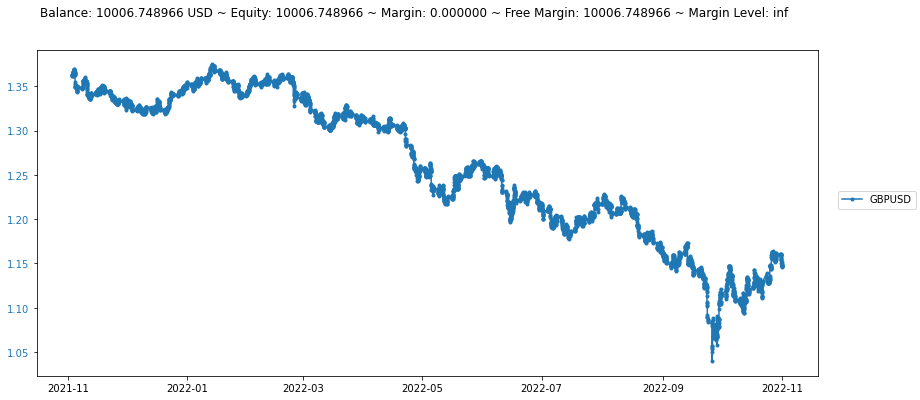

In [15]:
observation = test_env.reset()
while True:
    action, _states = model.predict(observation)
    observation, reward, done, info = test_env.step(action)
    if done:
        break

test_env.render('simple_figure')

In [16]:
state = test_env.render()

print(
    f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
    f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"
)


balance: 10006.748966289566, equity: 10006.748966289566, margin: 0.0
free_margin: 10006.748966289566, margin_level: inf



In [17]:
observation

{'balance': array([10006.74896629]),
 'equity': array([10006.74896629]),
 'margin': array([0.]),
 'features': array([[ 1.14797   ,  1.15061   ,  1.15158   ,  1.14755   ,  1.15660942,
          1.14460212, 34.62030297,  1.16545464,  1.15037836],
        [ 1.14995   ,  1.14797   ,  1.1514    ,  1.14794   ,  1.15627645,
          1.14465559, 38.92573439,  1.16579737,  1.14915663],
        [ 1.15134   ,  1.14994   ,  1.15285   ,  1.14809   ,  1.15602963,
          1.14472244, 41.75987924,  1.16556787,  1.14841813],
        [ 1.14864   ,  1.15133   ,  1.15165   ,  1.1483    ,  1.15566014,
          1.14476161, 38.14094572,  1.16538024,  1.14729876],
        [ 1.14682   ,  1.14863   ,  1.14903   ,  1.146     ,  1.15521814,
          1.1447822 , 35.93151245,  1.16526193,  1.14595807],
        [ 1.14703   ,  1.14684   ,  1.14776   ,  1.14643   ,  1.15480873,
          1.14480468, 36.37913638,  1.16510356,  1.14482044],
        [ 1.14676   ,  1.14705   ,  1.14731   ,  1.14603   ,  1.15440629,
 

In [18]:
state['orders']

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Profit,Margin,Fee,Closed
0,1,GBPUSD,Buy,0.1,2022-05-26 20:00:00+00:00,1.25808,2022-05-26 21:00:00+00:00,1.25941,6.748966,125.808,0.000655,True


In [19]:
df = state['orders']
df[df['Profit'] > 0 ]

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Profit,Margin,Fee,Closed
0,1,GBPUSD,Buy,0.1,2022-05-26 20:00:00+00:00,1.25808,2022-05-26 21:00:00+00:00,1.25941,6.748966,125.808,0.000655,True


In [20]:
# percentage winning trades
100*len(df[df['Profit'] > 0 ])/len(df)

100.0